# Probabilistic Programming 4: Latent Variable & Dynamic Models

#### Goal 
  - Understand how to estimate latent variables in models.
  - Understand how to estimate states in dynamical models.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on latent variable models
    - Lecture notes on dynamical models
  - Optional
    - [Review of latent variable models](https://doi.org/10.1146/annurev-statistics-022513-115657)
    - [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67)
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts from Bert's lectures become less abstract.

In [ ]:
using Pkg
Pkg.activate("./workspace")
Pkg.instantiate();

In [ ]:
using JLD
using Statistics
using StatsBase
using LinearAlgebra
using ProgressMeter
using ColorSchemes
using LaTeXStrings
using ForneyLab
using Plots
pyplot();

import LinearAlgebra: I
import ForneyLab: unsafeMean
include("../scripts/clusters.jl");
include("../scripts/filters.jl");

## Problem: Stone Tools

Archeologists have asked for your help in analyzing data on stone tools. It is believed that primitive humans created tools by striking stones with others. During this process, the stone loses flakes, which have been preserved. The archeologists have recovered these flakes from various locations and time periods and want to know whether this stone tool shaping process has improved over the centuries.

### Data

The data is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/StoneFlakes). Each instance represents summary information of the stone flakes for a particular site. We will be using the attributes _flaking angle_ (FLA) and the _proportion of the dorsal surface worked_ (PROZD) for now.

In [3]:
dataset = load("../datasets/stoneflakes.jld");

I've done some pre-processing on the data set, namely [z-scoring](https://nl.wikipedia.org/wiki/Z-score) and removing two outliers. This reduces the scale of the attributes which helps numerical stability during optimization. 

Now let's visualize the data with a scatterplot.

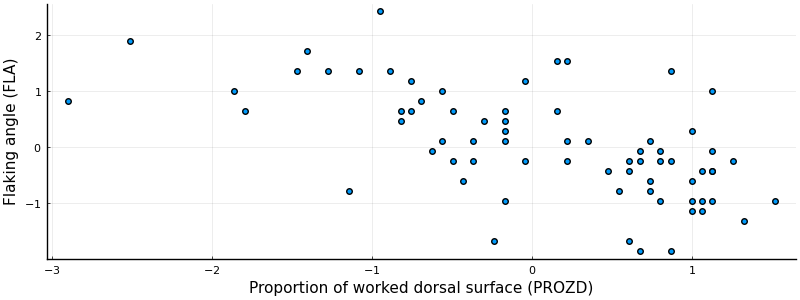

In [4]:
scatter(dataset["data"][:,1], 
        dataset["data"][:,2], 
        label="", 
        xlabel="Proportion of worked dorsal surface (PROZD)",
        ylabel="Flaking angle (FLA)",
        size=(800,300))

### Model specification

We will be clustering this data with a Gaussian mixture model, to see if we can identify clear types of stone tools. The generative model for a Gaussian mixture consists of:

$$ p(X, z, \phi, \mu, \Lambda) =\ \underbrace{p(X \mid z, \mu, \Lambda)}_{\text{likelihood}}\ \times \ \underbrace{p(z \mid \phi)}_{\text{prior latent variables}} \ \times \ \underbrace{p(\mu \mid \Lambda)\  p(\Lambda)\ p(\phi)}_{\text{prior parameters}}$$

with the likelihood of observation $X_i$ being a Gaussian raised to the power of the latent assignment variables $z$

$$ p(X_i \mid z, \mu, \Lambda) = \prod_{k=1}^{K} \mathcal{N}(X_i \mid \mu_k, \Lambda_k^{-1})^{z_i = k}$$

the prior for each latent variable $z_i$ being a Categorical distribution

$$ p(z_i \mid \phi) = \text{Categorical}(z_i \mid \phi) $$

and priors for the parameters being

$$ \begin{align*}
p(\mu_k \mid \Lambda_k) =&\ \mathcal{N}(\mu_k \mid m_0, l_0^{-1}\Lambda_k^{-1}) \qquad &\text{for all}\ k \\
p(\Lambda_k) =&\ \text{Wishart}(\Lambda_k \mid V_0, n_0) \qquad &\text{for all}\ k \\
p(\phi) =&\ \text{Dirichlet}(\phi \mid a_0) \, ,
\end{align*}$$

We will be implementing this model directly in ForneyLab. If you're unfamiliar with these distributions or with the Gaussian mixture model, have another look at Bert's lectures.

---

First, we will do a bit of bookkeeping.

In [5]:
# Data dimensionality
num_features = size(dataset["data"],2)

# Sample size
num_samples = size(dataset["data"],1)

# Number of mixture components
num_components = 3;

# Identity matrix (convenience variable)
Id = Matrix{Float64}(I, num_features, num_features);

Mixture models can be sensitive to initialization, so we are going to specify the prior parameters explicitly.

In [6]:
# Prior means
m0 = [ 1.0 0.0 -1.0;
      -1.0 0.0  1.0];

# Prior scale matrices
V0 = cat(Id, Id, Id, dims=3)

# Prior degrees of freedom 
n0 = num_features

# Prior concentration parameters
a0 = ones(num_components);

Now to start the factor graph. 

In [7]:
# Start a graph
graph1 = FactorGraph()

# Initialize vector variables
z = Vector{Variable}(undef, num_samples)
X = Vector{Variable}(undef, num_samples)
Λ = Vector{Variable}(undef, num_components)
μ = Vector{Variable}(undef, num_components)

# Mixture weights are drawn from a Dirichlet distribution
@RV ϕ ~ Dirichlet(a0)

θ = []
for k = 1:num_components
    
    # Parameters of k-th component
    @RV Λ[k] ~ Wishart(V0[:,:,k], n0)
    @RV μ[k] ~ GaussianMeanPrecision(m0[:,k], Λ[k])
    
    push!(θ, μ[k], Λ[k])
end

for i = 1:num_samples
    
    # Assignment variable
    @RV z[i] ~ Categorical(ϕ)
    
    # Gaussian mixture component
    @RV X[i] ~ GaussianMixture(z[i], θ...)
    
    # Add data 
    placeholder(X[i], :X, dims=(num_features,), index=i)
end

This is another _iid_ setting, which means the graph will be too large to visualize.

The next step is to compile an inference algorithm.

In [8]:
# Specify recognition factorization (mean-field)
q = PosteriorFactorization(ϕ, μ[1], Λ[1], μ[2], Λ[2], μ[3], Λ[3], z, 
                           ids=[:ϕ, :μ_1, :Λ_1, :μ_2, :Λ_2, :μ_3, :Λ_3, :z])

# Generate the algorithm
algorithm = messagePassingAlgorithm(free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true);
eval(Meta.parse(source_code));

After that, we feed in data, initialize recognition factors and run the inference procedure.

In [9]:
# Convert data to a format suited to ForneyLab
observations = [dataset["data"][i,:] for i in 1:num_samples]

# Add to data dictionary
data = Dict(:X => observations)

# Prepare recognition distributions
marginals = Dict()
marginals[:ϕ] = ProbabilityDistribution(Dirichlet, a=ones(num_components,))
for k = 1:num_components
    marginals[:μ_*k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m0[:,k], w=Id)
    marginals[:Λ_*k] = ProbabilityDistribution(Wishart, v=Id, nu=num_features)
end
for i = 1:num_samples
    marginals[:z_*i] = ProbabilityDistribution(Categorical, p=ones(num_components,)./num_components)
end

# Number of iterations
num_iterations = 20

# Preallocate free energy tracking array
F = Float64[]

# Execute algorithm
@showprogress for i = 1:num_iterations
    
    # Update assignments
    stepz!(data, marginals)
    
    # Update parameters
    stepϕ!(data, marginals)
    stepμ_1!(data, marginals)
    stepΛ_1!(data, marginals)
    stepμ_2!(data, marginals)
    stepΛ_2!(data, marginals)
    stepμ_3!(data, marginals)
    stepΛ_3!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


Alright, we're done. Let's track the evolution of free energy.

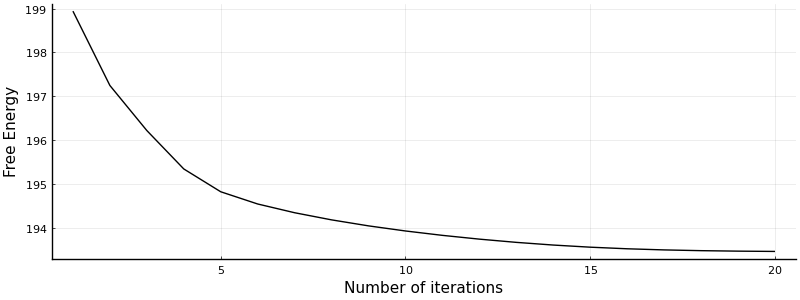

In [10]:
# Plot free energy to check for convergence
plot(1:num_iterations, F, color="black", label="", xlabel="Number of iterations", ylabel="Free Energy", size=(800,300))

That looks like it is nicely decreasing. We might want to increase the number of iterations a bit more.

Let's now visualize the cluster on top of the observations.

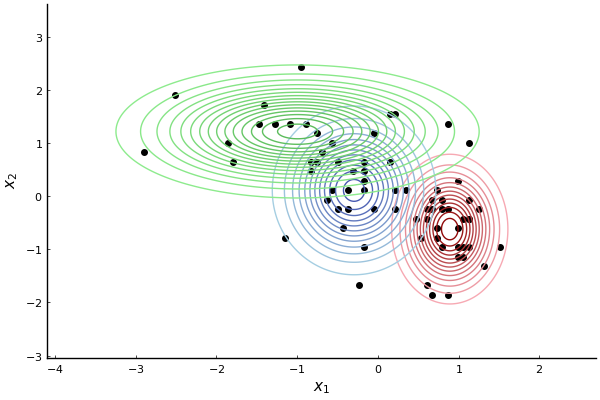

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [11]:
# Estimated means (unsafeMean retrieves parameters directly)
μ1_estimated = unsafeMean(marginals[:μ_1])
μ2_estimated = unsafeMean(marginals[:μ_2])
μ3_estimated = unsafeMean(marginals[:μ_3])

# Estimated precisions
Λ1_estimated = unsafeMean(marginals[:Λ_1])
Λ2_estimated = unsafeMean(marginals[:Λ_2])
Λ3_estimated = unsafeMean(marginals[:Λ_3])

# Invert to covariances
Σ1_estimated = inv(Λ1_estimated)
Σ2_estimated = inv(Λ2_estimated)
Σ3_estimated = inv(Λ3_estimated)

# Select dimensions to plot
dims_plot = [1, 2]
dim_limsx = [minimum(dataset["data"][:,dims_plot[1]])-1, maximum(dataset["data"][:,dims_plot[1]])+1]
dim_limsy = [minimum(dataset["data"][:,dims_plot[2]])-1, maximum(dataset["data"][:,dims_plot[2]])+1]

# Plot data and overlay estimated posterior probabilities
plot_clusters(dataset["data"][:, dims_plot], 
              μ=[μ1_estimated[dims_plot], μ2_estimated[dims_plot], μ3_estimated[dims_plot]], 
              Σ=[Σ1_estimated[dims_plot,dims_plot], Σ2_estimated[dims_plot,dims_plot], Σ3_estimated[dims_plot,dims_plot]], 
              x1=range(dim_limsx[1], step=0.01, stop=dim_limsx[2]), 
              x2=range(dim_limsy[1], step=0.01, stop=dim_limsy[2]),
              colorlist=[:reds, :blues, :greens],
              size=(600,400))

That doesn't look bad. The three Gaussians nicely cover all samples.

---

#### $\ast$ **Try for yourself**

Play around with the number of components. Can you get an equally good coverage with just 2 components? What if you had 4?

---

## Problem: Alpine Railways

The Swiss Federal Railways company operates a series of [mountain railways](https://en.wikipedia.org/wiki/List_of_mountain_railways_in_Switzerland) bringing hikers (in the summer) and skiers (in the winter) up the Alps. They are setting up a new fallback security system where they intend to track trains through cameras and remote sensors. They want you to design a system to keep track of the trains' positions. 

### Data

A train going uphill updates its position according to: new position = old position + velocity x length of time-step + noise. The noise represents the train randomly slipping and sliding back down. We observe the train through a remote sensor, producing noisy observations of its position. 

You receive a data set with past recordings. Your job is to set up an online filtering system, which can be deployed later on to process the incoming signal in real-time.

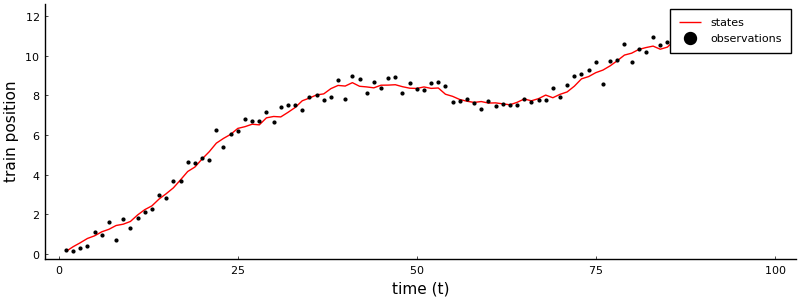

In [12]:
signal = load("../datasets/alpinerails_filtering.jld");

# Unpack data
states = signal["X"]
observations = signal["Y"]
transition = signal["A"]
emission = signal["C"]
process_noise = signal["Q"]
measurement_noise = signal["R"]
T = signal["T"]
Δt = signal["Δt"];

# Size
M = size(states,1)
N = size(observations,1)

# Visualize
plot(1:T, states[1,:], color="red", label="states", grid=false, xlabel="time (t)", ylabel="train position")
scatter!(1:T, observations[1,:], markersize=2, color="black", label="observations", size=(800,300))

### Model specification

We define noisy observations $y_k \in \mathbb{R}^{1}$ with latent states $x_k \in \mathbb{R}^{2}$. Observations $y_k$ are generated through a Gaussian likelihood centered on an emission matrix $C$ times the current state $x_k$ perturbed by measurement noise with covariance matrix $R$. State transitions follow a Gaussian distribution centered on a transition matrix $A$ times the previous state perturbed by process noise with covariance matrix $Q$. In equation form, these are:

$$\begin{align}
p(x_k \mid x_{k-1}) =&\ \mathcal{N}(x_k \mid A x_{k-1}, Q)\\
p(y_k \mid x_k) =&\ \mathcal{N}(y_k \mid C x_k, R) \, .
\end{align}$$

We have a prior for the previous state $x_{k-1} \sim \mathcal{N}(m_{k-1}, V_{k-1})$. In filtering problems, we feed the estimates of the current states as the parameters for the previous state in the next time-step.

In [13]:
# Initialize a graph
graph2 = FactorGraph()

# Define initial state prior
@RV x_kmin1 ~ GaussianMeanVariance(placeholder(:m_kmin1, dims=(M,)), 
                                   placeholder(:V_kmin1, dims=(M,M)))
    
# State transition
@RV x_k ~ GaussianMeanVariance(transition * x_kmin1, process_noise)
    
# Observation likelihood
@RV y_k ~ GaussianMeanVariance(dot(emission, x_k), measurement_noise)
    
# Tell FL that y is observed
placeholder(y_k, :y_k);

# Visualize subgraph
ForneyLab.draw(graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.49.3 (20211023.0002)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 584596593421247572 -->
 
 584596593421247572 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 1887571261257572615 -->
 
 1887571261257572615 
 
 placeholder_V_kmin1 
 
<!-- 584596593421247572--1887571261257572615 -->
 
 584596593421247572--1887571261257572615 
 
 V_kmin1 
 1 out 
 3 v 
 
<!-- 8849514731491899768 -->
 
 8849514731491899768 
 
 placeholder_m_kmin1 
 
<!-- 584596593421247572--8849514731491899768 -->
 
 584596593421247572--8849514731491899768 
 
 m_kmin1 
 1 out 
 2 m 
 
<!-- 8418212023744463102 -->
 
 8418212023744463102 
 
 clamp_2 
 
<!-- 10009430981943170616 -->
 
 10009430981943170616 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 10009430981943170616--8418212023744463102 -->
 
 10009430981943170616--8418212023744463102 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 4368958310473524364 -->
 
 4368958310473524364 
 
 × 
 multiplication_1 
 
<!-- 10009430981943170616--4368958310473524364 -->
 
 10009430981943170616--4368958310473524364 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 9615822109560011636 -->
 
 9615822109560011636 
 
 placeholder_y_k 
 
<!-- 13895501289166790465 -->
 
 13895501289166790465 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 9615822109560011636--13895501289166790465 -->
 
 9615822109560011636--13895501289166790465 
 
 y_k 
 1 out 
 1 out 
 
<!-- 10097055433464301533 -->
 
 10097055433464301533 
 
 clamp_4 
 
<!-- 13895501289166790465--10097055433464301533 -->
 
 13895501289166790465--10097055433464301533 
 
 clamp_4 
 1 out 
 3 v 
 
<!-- 3402431101778636432 -->
 
 3402431101778636432 
 
 dot 
 dotproduct_1 
 
<!-- 13895501289166790465--3402431101778636432 -->
 
 13895501289166790465--3402431101778636432 
 
 variable_2 
 1 out 
 2 m 
 
<!-- 317188845347885394 -->
 
 317188845347885394 
 
 clamp_3 
 
<!-- 6590413027789190061 -->
 
 6590413027789190061 
 
 clamp_1 
 
<!-- 4368958310473524364--584596593421247572 -->
 
 4368958310473524364--584596593421247572 
 
 x_kmin1 
 1 out 
 2 in1 
 
<!-- 4368958310473524364--6590413027789190061 -->
 
 4368958310473524364--6590413027789190061 
 
 clamp_1 
 1 out 
 3 a 
 
<!-- 3402431101778636432--10009430981943170616 -->
 
 3402431101778636432--10009430981943170616 
 
 x_k 
 1 out 
 2 in1 
 
<!-- 3402431101778636432--317188845347885394 -->
 
 3402431101778636432--317188845347885394 
 
 clamp_3 
 1 out 
 3 in2

We'll now construct the algorithm and infer results. 

In [14]:
# Generate inference algorithm
algorithm = messagePassingAlgorithm(x_k)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

For filtering, we use the same graph in each time-step.

In [15]:
# Initialize recognition distribution marginals
marginals = Dict(:x_k => vague(GaussianMeanVariance, M))

# Initialize message array
messages = Array{Message}(undef, 5)

# Keep track of estimates
m_x = 10*ones(M,T+1)
V_x = repeat(10*Matrix{Float64}(I,M,M), outer=(1,1,T+1))

@showprogress for k = 1:T
    
    # Initialize data
    data = Dict(:y_k => observations[k],
                :m_kmin1 => m_x[:,k],
                :V_kmin1 => V_x[:,:,k])
    
    # Update states
    step!(data, marginals, messages)
    
    # Store estimates
    m_x[:,k+1] = mean(marginals[:x_k])
    V_x[:,:,k+1] = cov(marginals[:x_k])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Let's check whether everything went ok. We'll visualize the state estimations.

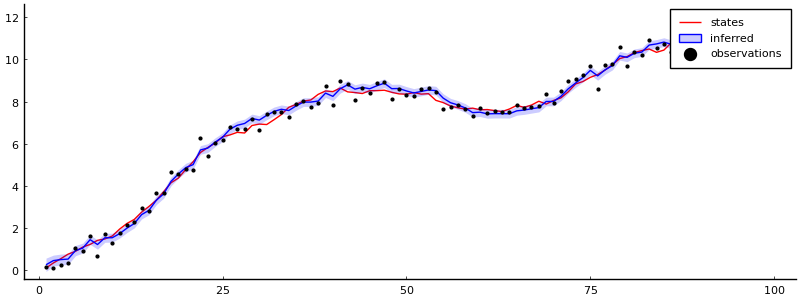

In [16]:
# Visualization
plot(1:T, states[1,:], color="red", label="states", grid=false)
plot!(1:T, m_x[1,2:end], ribbon=[sqrt.(V_x[1,1,2:end]), sqrt.(V_x[1,1,2:end])], fillalpha=0.2, color="blue", label="inferred")
scatter!(1:T, observations[1,:], markersize=2, color="black", label="observations", size=(800,300))

We're going to inspect some messages. Let's open up the algorithm and look up the marginal computation for the final $x_k$. It will be the multiplication of two messages, one consisting of the state transition prediction and the other consisting of the measurement likelihood. 

In [17]:
println(source_code)

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 5))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Multivariate, PointMass, m=data[:m_kmin1]), Message(MatrixVariate, PointMass, m=data[:V_kmin1]))
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=[1.0 0.1; 0.0 1.0]))
messages[3] = ruleSPGaussianMeanVarianceOutNGP(nothing, messages[2], Message(MatrixVariate, PointMass, m=[0.01 0.0; 0.0 0.1]))
messages[4] = ruleSPGaussianMeanVarianceMPNP(Message(Univariate, PointMass, m=data[:y_k]), nothing, Message(Univariate, PointMass, m=0.1))
messages[5] = ruleSPDotProductIn1GNP(messages[4], nothing, Message(Multivariate, PointMass, m=[1.0, 0.0]))

marginals[:x_k] = messages[3].dist * messages[5].dist

return marginals

end

end # block


Alright, we need messages 3 and 5. Let's visualize them along with the state marginal.

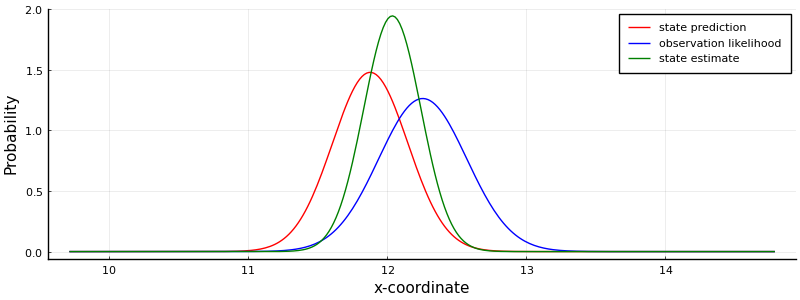

In [18]:
# Collect state transition prediction
m_statepred = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[3].dist)

# Collect observation likelihood
m_likelihood = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[5].dist)

# Collect corrected prediction
state_marginal = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:x_k])

# # Extract x-coordinates
m_statepred_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_statepred.params[:m][1], v=m_statepred.params[:v][1,1])
m_likelihood_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_likelihood.params[:m][1], v=m_likelihood.params[:v][1,1])
state_marginal_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=state_marginal.params[:m][1], v=state_marginal.params[:v][1,1])

# Plot of the prediction, noisy measurement, and corrected prediction for x-coordinate
plot_messages(m_statepred_x, m_likelihood_x, state_marginal_x, size=(800,300))

As you can see, the state estimate is a combination of the state prediction, produced by the message from the state transition node, and the observation likelihood, produced by the message from the likelihood. 

---

#### $\ast$ **Try for yourself**

Re-run the inference procedure and stop at an earlier time-step, for example $k$=2. How does the balance between the state prediction and the observation likelihood differ?

---